In [1]:
#%matplotlib notebook
import time, winsound, h5py, os
import numpy as np
import matplotlib.pyplot as plt
from lcls_beamline_toolbox.xraybeamline2d import beam1d as beam, optics1d as optics, beamline1d as beamline
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
from Functions import *
from LCLS_Optics import *

In [2]:
N = 256       # number of sampling points
E0 = 9.9e3    # photon energy in eV
z_off=.12     # distance offset between VCC crystal 1 and CC crystal 1
d23=.2        # distance between VCC crystal 2 and 3
f_lens = .085 # spectrometer lens focal distance
FOV1 = 2e-3   # [m]
FOV2 = 1e-3 # [m]
alphaAsym = np.deg2rad(2)

tau = 3
window = 2000
tau_chirp = 100

# group delay dispersion [fs^2]
GDD = np.sqrt( (np.square(tau_chirp*tau)-tau**4) / (16*np.square(np.log(2))) )

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 50e-6/(2*np.sqrt(2*np.log(2))),
    'sigma_y': 50e-6/(2*np.sqrt(2*np.log(2))),
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 0
}

print(GDD)

108.15342614864406


Text(0.5, 1.0, 'linear chirp')

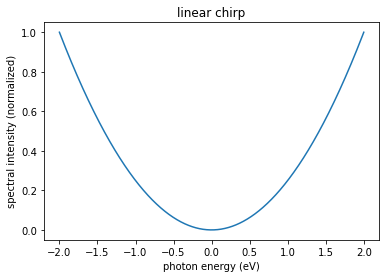

In [3]:
''' phase profile '''
axis_eV = np.linspace(-2,2,1001)  # photon energy around carrier frequency
axis_w = E2f(axis_eV) * np.pi * 2
int_w = GDD * np.square(axis_w)/2
plt.figure()
plt.plot(axis_eV, int_w/int_w.max())
plt.xlabel('photon energy (eV)')
plt.ylabel('spectral intensity (normalized)')
plt.title('linear chirp')

In [4]:
# crystal stretching calculation
test_crystal = optics.Crystal('c_test', hkl=[1,1,1], length=10e-2, width=10e-3, z=0, E0=E0,
                              alphaAsym=np.deg2rad(5), orientation=2, pol='p', asym_type='emergence')


b 2.50


In [5]:
''' define beamline '''
def define_branch_VCC(E0=9000, z_off=.12, d23=.2, alphaAsym=np.deg2rad(5), f_lens=10., FOV1 = 1e-3, FOV2 = 100e-6, N = 1024):
    # crystal reflection hkl index
    hkl = [2,2,0]

    # viewing point upstream of monochromator
    im0 = optics.PPM('im0', z=400-.01, FOV=FOV1, N=N)

    slit = optics.Slit('s0', x_width=1., y_width=100e-3, dx=0, dy=-50e-3, z=400)
    
    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=400+z_off, E0=E0,
                              alphaAsym=0, orientation=2, pol='s', delta=0.e-6)
    
    # second crystal: asymmetric reflection, orientation flipped relative to crystal 1
    z12 = np.cos(2*crystal1.beta0)*0.02
    crystal2 = optics.Crystal('c2', hkl=hkl, length=10e-2, width=20e-3, z=crystal1.z+z12, E0=E0,
                              alphaAsym=alphaAsym, orientation=0, pol='s', delta=0.e-6)
    
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    im1 = optics.PPM('im1', z=crystal2.z+d23/2, FOV=FOV1, N=N)

    # third crystal, symmetric reflection, same orientation as crystal2
    z23 = d23
    crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=crystal2.z+z23, E0=E0,
                              alphaAsym=-alphaAsym, orientation=0, pol='s', asym_type='emergence')

    # fourth crystal, asymmetric reflection, same orientation as crystal1
    z34 = z12
    crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=crystal3.z+z34, E0=E0,
                              alphaAsym=0, orientation=2, pol='s', asym_type='emergence')

    # viewing point just downstream of monochromator
    im2 = optics.PPM('im2', z=crystal4.z+z_off+.01, FOV=FOV1, N=N)
    
    # spectrometer lens
    crl1 = CRL_no_abs('crl1', z=im2.z+.01, E0=E0, f=f_lens, diameter=5e-3, orientation=1)
    
    # viewing point at spectrometer lens focal plane
    im3 = optics.PPM('im3', z=crl1.z+f_lens, FOV=FOV2, N=N)
    
    # spectrometer crystal
    crystal5 = optics.Crystal('c5', hkl=[5,5,5], length=10e-2, width=10e-2, z=crl1.z+f_lens*2, E0=E0,
                              alphaAsym=0, orientation=1, pol='s', asym_type='emergence')
        
    # viewing point at crossing
    z56 = np.cos(np.pi-2*crystal5.alpha)*.5
    
    im4 = optics.PPM('im4', z=crystal5.z-z56, FOV=FOV2, N=N)
    
    # list of devices to propagate through
    devices = [im0, crystal1, crystal2, im1, crystal3, crystal4, im2,
               crl1, im3, crystal5, im4]

    return devices

def define_branch_CC(E0=9000, d23 = .2, alphaAsym=np.deg2rad(0), f_lens=10., FOV1 = 1e-3, FOV2 = 100e-6, N = 1024):
    # crystal reflection hkl index
    hkl = [2,2,0]

    # viewing point upstream of monochromator
    im0 = optics.PPM('im0', z=400-.01, FOV = FOV1, N=N)
    
    slit = optics.Slit('s0', x_width=1., y_width=100e-3, dx=0, dy=50e-3, z=400)

    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=400, E0=E0,
                              alphaAsym=0, orientation=0, pol='s', delta=0.e-6)
    
    # second crystal: symmetric reflection, orientation flipped relative to crystal 1
    z12 = np.cos(2*crystal1.beta0)*0.02
    crystal2 = optics.Crystal('c2', hkl=hkl, length=10e-2, width=20e-3, z=crystal1.z+z12, E0=E0,
                              alphaAsym=alphaAsym, orientation=2, pol='s', delta=0.e-6)
    
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    im1 = optics.PPM('im1', z=crystal2.z+d23/2+z_off, FOV=FOV1, N=N)

    # third crystal, symmetric reflection, same orientation as crystal2
    z23 = d23 + 2*z_off
    crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=crystal2.z+z23, E0=E0,
                              alphaAsym=-alphaAsym, orientation=2, pol='s', asym_type='emergence')

    # fourth crystal, symmetric reflection, same orientation as crystal1
    z34 = z12
    crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=crystal3.z+z34, E0=E0,
                              alphaAsym=0, orientation=0, pol='s', asym_type='emergence')
    
    # viewing point just downstream of monochromator
    im2 = optics.PPM('im2', z=crystal4.z+.01, FOV=FOV1, N=N)
    
     # spectrometer lens
    crl1 = CRL_no_abs('crl1', z=im2.z+.01, E0=E0, f=f_lens, diameter=5e-3, orientation=1)

    # viewing point at spectrometer lens focal plane
    im3 = optics.PPM('im3', z=crl1.z+f_lens, FOV=FOV2, N=N)
        
    # spectrometer crystal
    crystal5 = optics.Crystal('c5', hkl=[5,5,5], length=10e-2, width=10e-2, z=crl1.z+f_lens*2, E0=E0,
                              alphaAsym=0, orientation=1, pol='s', asym_type='emergence')
    
    # viewing point at crossing
    z56 = np.cos(np.pi-2*crystal5.alpha)*.5
    im4 = optics.PPM('im4', z=crystal5.z-z56, FOV=FOV2, N=N)

    # list of devices to propagate through
    devices = [im0, crystal1, crystal2, im1, crystal3, crystal4, im2,
               crl1, im3, crystal5, im4]

    return devices


### Beamline components:

Crystal orientation:
    0: beam turns to +x
    1: beam turns to +y
VCC:
    C1-4 (H, mono), im2, C5 (V, spectrometer), im3, lens (V, spectrometer), im4 (focus)
    
CC:
    C1-4 (H, mono), im2, C5 (V, spectrometer), im3, lens (V, spectrometer), im4 (focus)

In [6]:
# initialize optical elements
devices_VCC = define_branch_VCC(E0=E0, z_off=z_off, d23=d23, alphaAsym=alphaAsym, f_lens=f_lens, FOV1=FOV1, FOV2=FOV2, N=N)
branch_VCC = beamline.Beamline(devices_VCC, ordered=True)
for oe in devices_VCC:
    if oe.name == 'c4':
        print('VCC crystal 4 incidence angle: {:.2f} degrees'.format(oe.alpha*180/np.pi))
        print('VCC crystal 4 exit angle: {:.2f} degrees\n\n\n'.format(oe.beta0*180/np.pi))
        
devices_CC = define_branch_CC(E0=E0, d23=d23, f_lens=f_lens, FOV1=FOV1, FOV2=FOV2, N=N)
branch_CC = beamline.Beamline(devices_CC, ordered=True)
for oe in devices_CC:
    if oe.name == 'c4':
        print('CC crystal 4 incidence angle: {:.2f} degrees'.format(oe.alpha*180/np.pi))
        print('CC crystal 4 exit angle: {:.2f} degrees\n\n\n'.format(oe.beta0*180/np.pi))


b 1.00
b 1.23
crystal 2 incidence angle: 21.03 degrees
crystal 2 exit angle: 17.03 degrees
b 0.82
b 1.00
b 1.00
after c1: -0.6644
after c2: 0.0000
after c3: 0.6644
after c4: 0.0000
after c5: 3.0341
VCC crystal 4 incidence angle: 19.03 degrees
VCC crystal 4 exit angle: 19.03 degrees



b 1.00
b 1.00
crystal 2 incidence angle: 19.03 degrees
crystal 2 exit angle: 19.03 degrees
b 1.00
b 1.00
b 1.00
after c1: 0.6644
after c2: 0.0000
after c3: -0.6644
after c4: 0.0000
after c5: 3.0341
CC crystal 4 incidence angle: 19.03 degrees
CC crystal 4 exit angle: 19.03 degrees





In [7]:
for device in devices_VCC:
    print(device.name, device.z)

im0 399.99
c1 400.12
c2 400.13574529055575
im1 400.23574529055577
c3 400.33574529055574
c4 400.3514905811115
im2 400.4814905811115
crl1 400.49149058111146
im3 400.57649058111144
c5 400.6614905811115
im4 400.1643767036557


In [8]:
%%capture capt
tstart = time.time()
# propagate
beam_params['photonEnergy'] = E0
pulse_VCC = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window, GDD=GDD)
pulse_CC = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window, GDD=GDD)
pulse_VCC.propagate(beamline=branch_VCC, screen_names=['im2','im3','im4'])
pulse_CC.propagate(beamline=branch_CC, screen_names=['im2','im3','im4'])
tfin = time.time()

In [9]:
path = 'LCLS_output/'
make_dir(path)

case_path = path+'ray_tracing_chirp/'
make_dir(case_path)

fig_path = case_path+'{} fs/'.format(tau)
make_dir(fig_path)

print('propagation lasted {}s'.format(round(tfin-tstart,2)))

path exists
make path
make path
propagation lasted 779.12s


In [10]:
''' beam profiles '''
im_names = ['im2', 'im3', 'im4']
part_names = ['1.mono', '2.lens_focus', '3.crossing']

for i in range(len(im_names)):
    im_name = im_names[i]
    part_name = part_names[i]
    
    # spatial projection (xy)
    pulse_VCC.imshow_projection(im_name)
    plt.savefig(fig_path+'profile_VCC_{}.png'.format(part_name))
    pulse_CC.imshow_projection(im_name)
    plt.savefig(fig_path+'profile_CC_{}.png'.format(part_name))
    plt.close('all')
    # time and energy component slice (x/y vs t/E)
    for dim in ['x','y']:
        pulse_VCC.imshow_time_slice(im_name, dim=dim)
        plt.savefig(fig_path+'tilt_{}_VCC_{}.png'.format(dim,part_name))
        pulse_CC.imshow_time_slice(im_name, dim=dim)
        plt.savefig(fig_path+'tilt_{}_CC_{}.png'.format(dim,part_name))
        plt.close('all')
        pulse_VCC.imshow_energy_slice(im_name, dim=dim)
        plt.savefig(fig_path+'spectrum_{}_VCC_{}.png'.format(dim, part_name))
        pulse_CC.imshow_energy_slice(im_name, dim=dim)
        plt.savefig(fig_path+'spectrum_{}_CC_{}.png'.format(dim, part_name))
        plt.close('all')

In [11]:
''' crossing '''
offset = 0.

im_name = im_names[-1]
part_name = part_names[-1]+'_{}fs_offset'.format(offset)

# add branches
t_shift = find_shift(pulse_VCC, pulse_CC, im_name)+offset
pulse_sum = pulse_VCC.add_pulse(pulse_CC, t_shift)

# spatial projection (xy)
pulse_sum.imshow_projection(im_name)
plt.savefig(fig_path+'profile_Sum_{}.png'.format(part_name))
plt.close('all')
# time and energy component slice (x/y vs t/E)
for dim in ['x','y']:
    pulse_sum.imshow_time_slice(im_name, dim=dim)
    plt.savefig(fig_path+'tilt_{}_Sum_{}.png'.format(dim,part_name))
    pulse_sum.imshow_energy_slice(im_name, dim=dim)
    plt.savefig(fig_path+'spectrum_{}_Sum_{}.png'.format(dim, part_name))
    plt.close('all')

In [12]:
import winsound
winsound.PlaySound("*", winsound.SND_ALIAS)
winsound.PlaySound("*", winsound.SND_ALIAS)
winsound.PlaySound("*", winsound.SND_ALIAS)

In [13]:
# vertically go through an asymmetric crystal, b>1; then add a crl lens so both branches go through a spectrometer, plot spectrum (E vs t) to see if they overlap.
# if not, add a prism in one branch so that the spectrums overlaps. once overlapped, add both branches together.
# can make a branch tilt more so that not fringe everywhere.

# 1. no energy chirp (straight fringe)
# 2. only energy chirp (tilting fringe)

# the above two for proposal, see their difference

# 3. energy and spatial chirp ()

In [14]:
### todo

# move im4 1 or 2 Rayleigh ranges before and after focal plane to see if sensitive.
# add small prism in one branch before lens (to change difference in divergence to curvature)